# Problem Set 1: TensorFlow [50 pts]
#### _Due date: Oct 12, 11:59pm_
_Submission instructions will be posted separately on Piazza_

**Note**: The following has been verified to work with TensorFlow 2.0

\* Adapted from official TensorFlow&trade; tour guide.

TensorFlow is a powerful library for doing large-scale numerical computation. One of the tasks at which it excels is implementing and training deep neural networks. In this assignment you will learn the basic building blocks of a TensorFlow model while constructing a deep convolutional MNIST classifier.

What you are expected to implement in this tutorial:

* Create a softmax regression function that is a model for recognizing MNIST digits, based on looking at every pixel in the image

* Use Tensorflow to train the model to recognize digits by having it "look" at thousands of examples

* Check the model's accuracy with MNIST test data

* Build, train, and test a multilayer convolutional neural network to improve the results


## Data

After importing tensorflow, we can download the MNIST dataset with the built-in TensorFlow/Keras method.

In [1]:
! pip install matplotlib

## Build the CNN

In this part we will build a customized TF2 Keras model. As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. For MNIST, you will configure our CNN to process inputs of shape (28, 28, 1), which is the format of MNIST images. You can do this by passing the argument input_shape to our first layer.

The overall architecture should be:

```
Model: "customized_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_2 (Conv2D)            multiple                  320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  18496     
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  7930880   
_________________________________________________________________
dense_3 (Dense)              multiple                  10250     
=================================================================
Total params: 7,959,946
Trainable params: 7,959,946
Non-trainable params: 0
_________________________________________________________________
```
### First Convolutional Layer [5 pts]

We can now implement our first layer. The convolution will compute 32 features for each 3x3 patch. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels.

### Max Pooling Layer [5 pts]

We stack max pooling layer after the first convolutional layer. These pooling layers will perform max pooling for each 2x2 patch.

### Second Convolutional Layer [5 pts]

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 3x3 patch.


### Fully Connected Layers [10 pts]

Now that the image size has been reduced to 11x11, we add a fully-connected layer with 128 neurons to allow processing on the entire image. We reshape the tensor from the second convolutional layer into a batch of vectors before the fully connected layer.

The output layer should also be implemented via a fully connect layer.


### Complete the Computation Graph [15 pts]

Please complete the following function:

```def call(self, inputs, training=None, mask=None):```

To apply the layer, we first reshape the input to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels (which is 1).

We then convolve the reshaped input with the first convolutional layer and then the max pooling followed by the second convolutional layer. These convolutional layers and the pooling layer will reduce the image size to 11x11.

### Dropout Layer [5 pts]
Please add dropouts during training before each fully connected layers, as this helps avoid overfitting during training.
https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

In [2]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.python.keras import Sequential 

os.environ['OMP_NUM_THREADS'] = '1'
tf.__version__

'2.3.1'

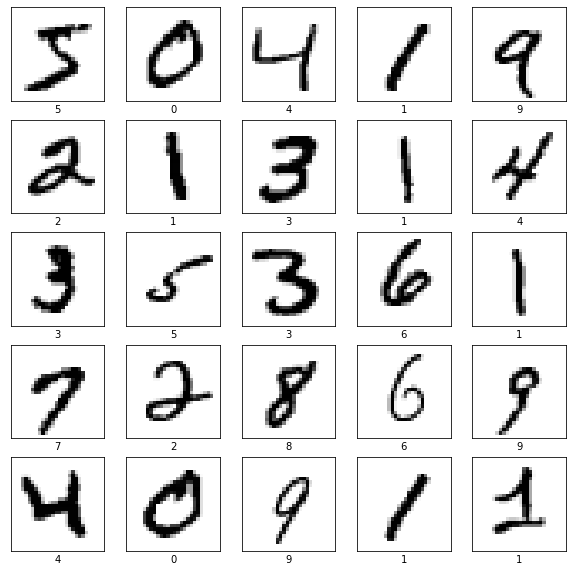

[7 2 1 ... 4 5 6]


In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

print(test_labels)

In [5]:
class CustomizedCNN(tf.keras.models.Model):

    def __init__(self, *args, **kwargs):
        super(CustomizedCNN, self).__init__()
        self.conv2d1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1))
        self.max_pooling_2d = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1))
        self.conv2d2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')
        self.flatted = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(234)
        self.dense2 = tf.keras.layers.Dense(44)
#         model = tf.keras.models.Sequential()
#         model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
#         model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
#         model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        #raise NotImplementedError('Implement Using Keras Layers.')

    def call(self, inputs, training=None, mask=None):
        x = tf.expand_dims(inputs, axis=-1)
        x = self.conv2d1(x)
        x = self.max_pooling_2d(x)
        x = self.conv2d2(x)
        x = self.flatted(x)
        x = self.dense1(x)
        return self.dense2(x)
        #raise NotImplementedError('Build the CNN here.')

print(":\ Complete.")

:\ Complete.


## Build the Model

In [6]:
model = CustomizedCNN()
model.build(input_shape=(None, 28, 28))
model.summary()

Model: "customized_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7922538   
_________________________________________________________________
dense_1 (Dense)              multiple                  10340     
Total params: 7,951,694
Trainable params: 7,951,694
Non-trainable params: 0
__________________________________________

We can specify a loss function just as easily. Loss indicates how bad the model's prediction was on a single example; we try to minimize that while training across all the examples. Here, our loss function is the cross-entropy between the target and the softmax activation function applied to the model's prediction. As in the beginners tutorial, we use the stable formulation:

In [7]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

print(":\ Complete")

:\ Complete


## Train and Evaluate the Model [5 pts]

We will use a more sophisticated ADAM optimizer instead of a Gradient Descent Optimizer.

Feel free to run this code. Be aware that it does 10 training epochs and may take a while (possibly up to half an hour), depending on your processor.

The final test set accuracy after running this code should be approximately 98.7%  -- not state of the art, but respectable.

We have learned how to quickly and easily build, train, and evaluate a fairly sophisticated deep learning model using TensorFlow.

In [7]:
# # Preprocess the data (these are NumPy arrays)
# train_images = train_images.reshape(60000, 784).astype("float32") / 255
# test_images = test_images.reshape(10000, 784).astype("float32") / 255

# train_labels = train_labels.astype("float32")
# test_labels = test_labels.astype("float32")

# # Reserve 10,000 samples for validation
# x_val = train_images[-10000:]
# y_val = train_labels[-10000:]
# x_train = train_images[:-10000]
# y_train = train_labels[:-10000]

#raise NotImplementedError('Update correct arguments for the fit method below.')
# history = model.fit(train_images, train_labels, epochs=5) # Use correct args here.

#x = tf.expand_dims(inputs, axis=-1)

# image = tf.image.decode_jpeg(train_images)
# image = tf.cast(image, tf.float32)

def show_shapes(): # can make yours to take inputs; this'll use local variable values
    print("Expected: (num_samples, timesteps, channels)")
    print("Sequences: {}".format(train_images.shape))
    print("Targets:   {}".format(train_labels.shape))   

x_images = np.asarray(train_images)
x_labels   = np.asarray(train_labels)
show_shapes()

y_images = np.expand_dims(x_images, -1)
y_targets  = np.expand_dims(x_labels, -1)
show_shapes()

x_train = train_images.reshape(train_images.shape[0], 28, 28, 1)
x_test = test_images.reshape(test_images.shape[0], 28, 28, 1)

history = model.fit(x_train, y_targets, epochs=10)

Expected: (num_samples, timesteps, channels)
Sequences: (60000, 28, 28)
Targets:   (60000,)
Expected: (num_samples, timesteps, channels)
Sequences: (60000, 28, 28)
Targets:   (60000,)
Epoch 1/10


TypeError: in user code:

    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    <ipython-input-4-bd4617ac2f70>:19 call  *
        x = self.conv2d1(x)
    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py:247 call
        outputs = self._convolution_op(inputs, self.kernel)
    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:1017 convolution_v2
        name=name)
    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:1147 convolution_internal
        name=name)
    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:2602 _conv2d_expanded_batch
        name=name)
    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:313 squeeze_batch_dims
        out_reshaped = op(inp_reshaped)
    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/gen_nn_ops.py:979 conv2d
        data_format=data_format, dilations=dilations, name=name)
    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:578 _apply_op_helper
        param_name=input_name)
    /Users/ginomcfino/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:61 _SatisfiesTypeConstraint
        ", ".join(dtypes.as_dtype(x).name for x in allowed_list)))

    TypeError: Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64, int32


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels)
print(test_acc)